# Digit Recognition - Paper Implementation

In my exploration of handwritten digit classification, I decided to read and reimplement the 1989 paper *Handwritten Digit Recognition with a Back-Propagation Network (LeCun, 1989)*, which proposed a 4-layer **Convolutional Neural Network** for the task of correctly classifying the USPS handwritten digit dataset. This following report documents my reproduction of the neural network on the more "modern" **MNIST** dataset. The model architecture and data preprocessing havee been kept true to the original paper. Using the given model, an accuracy of **96.4%** has been reproduced. 

In [1]:
# Setting path for proper imports 
import sys
import os
sys.path.append(os.path.abspath('..'))


In [13]:
# Importing all Relevant Modules
import torch
import numpy as np
import matplotlib.pyplot as plt
import data.utils as data
import training.train as train
from models.LeNet1989 import LeNet1989

## Preprocessing of Data

For the preprocessing of the data, the images are scaled to **16x16** pixels, before being imbedded in a **28x28** image. The pixel values are normalized to be in the interval $[-1, 1]$. The **border padding** (effective 6 added pixles on all sides) is added for consistent treatment of the border. That way the convolutional kernel does not run into feautures right away, preventing **information loss** and leading to more accurate results. An example output of a processed image can be seen below. 

In [ ]:
(x_train, y_train), (x_test, y_test) = data.get_prepared_data()

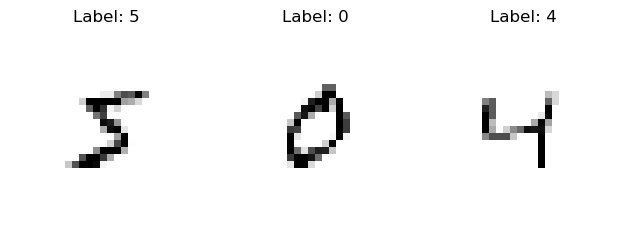

In [4]:
train_set = data.create_dataset(x_train, y_train)
test_set = data.create_dataset(x_test, y_test)

img1 = x_train[0]
img2 = x_train[1]
img3 = x_train[2]

fig, axes = plt.subplots(1, 3)

axes[0].imshow(img1, cmap='gray_r')
axes[0].set_title("Label: {}".format(y_train[0]))
axes[0].axis('off')  

axes[1].imshow(img2, cmap='gray_r')
axes[1].set_title("Label: {}".format(y_train[1]))
axes[1].axis('off')

axes[2].imshow(img3, cmap='gray_r')
axes[2].set_title("Label: {}".format(y_train[2]))
axes[2].axis('off')

plt.tight_layout()
plt.show()

## Model Architecture & Training - LeNet1989

### Architecture
The model architecture consists of a **28x28 input layer**, followed by **4 hidden layers**, and finally a **10-class output layer**. The following table dislplays the number of feature maps and the respective kernel and output sizes. 


| Layer | No. feature maps | Size  | Type          |
|-------|------------------|-------|---------------|
|   H1  | 4                | 24x24 |5x5 Kernel     |
|   H2  | 4                | 12x12 |2x2 Avg Pool   |
|   H3  | 12               | 8x8   |5x5 Kernel     |
|   H4  | 12               | 4x4   |2x2 Avg Pool   |


Layer **H4** is then flattened and fully connected to the output layer. The **output layer** consists of 10 nodes representing the 10 classes of handwritten digits. 

A key design choice of this paper is the **partial connectivity** between H2 and H3. This significantly reduces the **parameter count** of the model, significantly speeding up the training on the 1989 hardware. This also causes a more **feature-diverse** learning, avoiding redundant representations. 

### Training

The training mechanism uses **Simple Gradient Descent** as its optimizer and relies on **Mean Squared Error Loss** as its loss function. Particularly **MSE** in now know to not be ideal for classification tasks (**Cross-Entropy** sinificantly outperforms it) however for the sake of reproducing the original results, **MSE** will be used. The **learning rate** is 0.1 and the **momentum** is 0.9. Similarly to (LeCun, 1989), training is run for **30 epochs**. During training, the **training loss**, **training accuracy**, **validation loss**, and **validation accuracy** are logged for deeper insight into training mechanics. 



In [ ]:
# instantiattion of the model
le_net = LeNet1989()

# trained model is saved by default in "LeNet1989.pt"
df = train.train_LeNet1989(train_data = train_set, test_data=test_set, model=le_net, n_epochs=30)


## Model Evaluation

After 30 passes through the training set, the model reaches a validation accuracy of around **96.2%**, effectively reproducing the papers **error-rate** of around **3.4%** (slight deviations due to the use of MNIST instead of USPS). In the following section, plots to determine model performance and evaluate training infrastructure. 

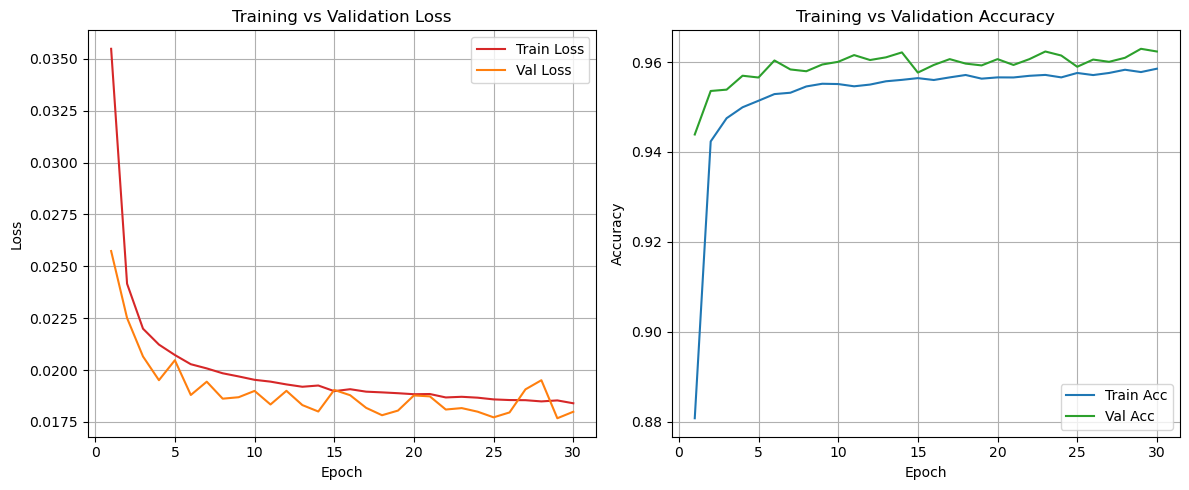

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# ---- Left: Loss curves ----
axes[0].plot(df["epoch"], df["train_loss"], label="Train Loss", color="tab:red")
axes[0].plot(df["epoch"], df["val_loss"], label="Val Loss", color="tab:orange")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training vs Validation Loss")
axes[0].legend()
axes[0].grid(True)

# ---- Right: Accuracy curves ----
axes[1].plot(df["epoch"], df["train_acc"], label="Train Acc", color="tab:blue")
axes[1].plot(df["epoch"], df["val_acc"], label="Val Acc", color="tab:green")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Training vs Validation Accuracy")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

### Loss and Accuracy

As previously stated, the reproduced model converges to an accuracy of about **96.2%** with an **MSE-Loss** of around **0.018**. These values are consistent with the paper. It can be seen that accuracy initially improves rapidly, atbilizing at **95+%** after just 10 epochs. This model has a **stable learning curve** meaning there is a lack of significant oscilations or divergence. 

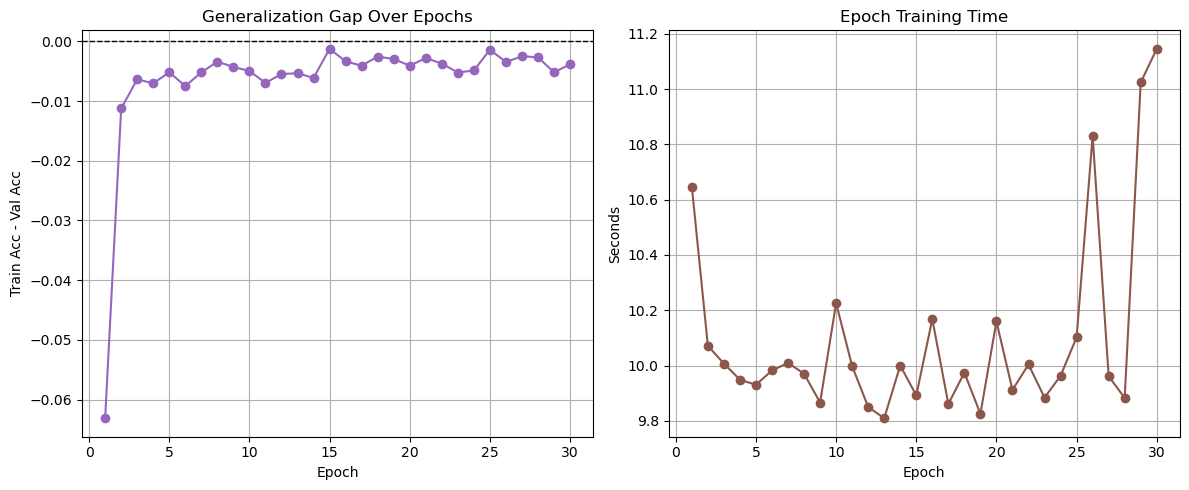

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# ---- Left: Generalization Gap ----
axes[0].plot(df["epoch"], df["gen_gap"], marker="o", color="tab:purple")
axes[0].axhline(0, linestyle="--", color="black", linewidth=1)
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Train Acc - Val Acc")
axes[0].set_title("Generalization Gap Over Epochs")
axes[0].grid(True)

# ---- Right: Epoch Time ----
axes[1].plot(df["epoch"], df["epoch_time"], marker="o", color="tab:brown")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Seconds")
axes[1].set_title("Epoch Training Time")
axes[1].grid(True)

plt.tight_layout()
plt.show()

### Overfitting and Efficiency

The **generalization gap** is defined as $acc_{train} - acc_{val}$ and is used to determine whether the model is overfitting. As seen in the plot, the gap converges to **~-1%** after just a couple of epochs. This indicates that training and validation accuracy are similar, meaning the model is **learning to classify** rather than **"remebering"** the data. The **negative generalization gap** indicates a very good generalization, meaning that the validation set gets classified better than the training set. This is linked to the partially connected **H3-Layer**, which encourages feature diversity and avoids all maps in H3 learning the same features. 

As seen by the **Epoch Training Time** the model passes through the training set fastly, taking between $9.8s-11.2s$ per epoch. This can be traced back to the leightweight model architecture, particularly the small depth, and partial connectivity of Layer H3. This graph will be particularly interesting when compared to the [modern CNN](mod_CNN.ipynb).

## Model Visualization

An advantage of CNN architectures is the ability to **visualize** the learned kernels and feature maps. 

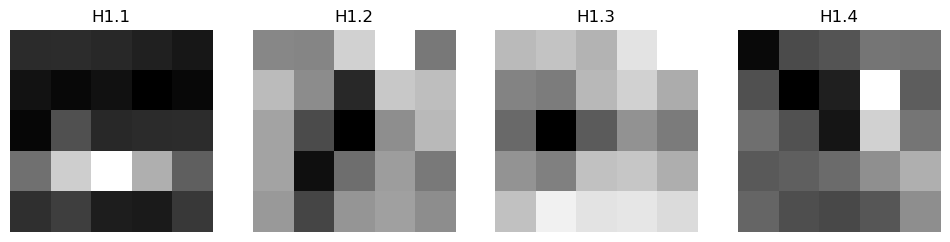

In [51]:
model = torch.load("LeNet1989.pt", weights_only=False)
model.eval()

weights = model.H1.weight.data.clone()

fig, axes = plt.subplots(1, 4, figsize=(12, 6))

for i, ax in enumerate(axes.flat, start=1):
    ax.imshow(weights[i-1, 0].cpu(), cmap="gray")  # first channel
    ax.axis("off")
    ax.set_title(f"H1.{i}")  # individual subtitle


plt.show()

The plot above visualizes the learned Kernels from the H1 layer. These behave consistently with typical convolutional feature detection. Possible feature detection looks as follows:

| Kernel | Feature Detection   | 
|--------|---------------------|
|   H1.1 | Horizontal Line     | 
|   H1.2 | Diagonal Edge/Corner| 
|   H1.3 | Blob                | 
|   H1.4 | Strong Edge         | 

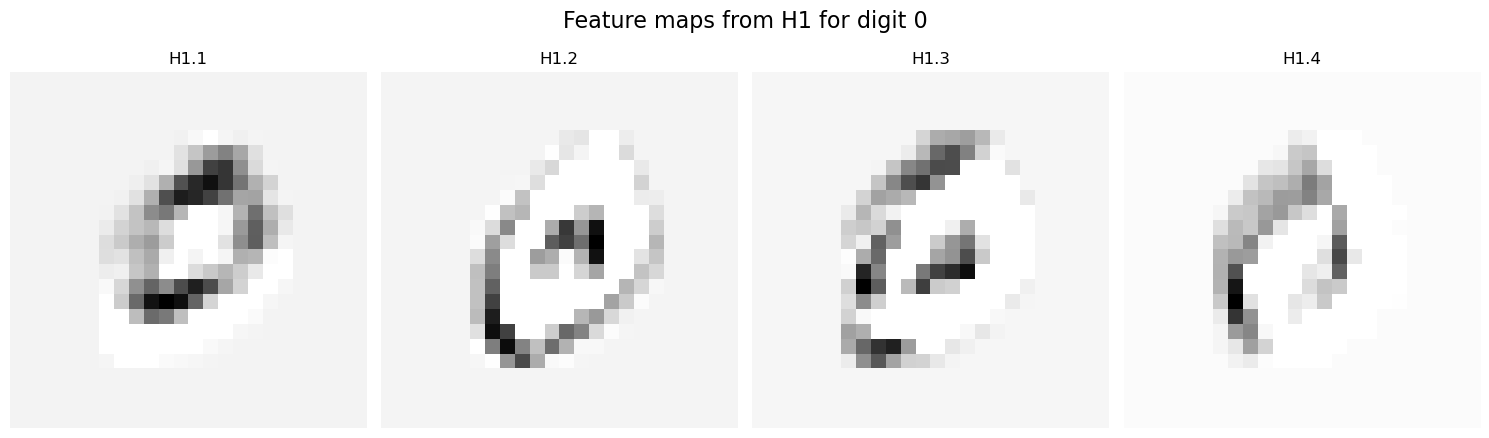

In [47]:
img, label = train_set[1]

img = img.unsqueeze(0)

with torch.no_grad():
    h1_out = torch.nn.functional.relu(model.H1(img))

feature_maps = h1_out.squeeze(0).cpu()

# ---- Plot feature maps ----
num_maps = feature_maps.shape[0]
fig, axes = plt.subplots(1, num_maps, figsize=(15, 5))

for i in range(num_maps):
    axes[i].imshow(feature_maps[i], cmap="gray_r")
    axes[i].axis("off")
    axes[i].set_title(f"H1.{i+1}")


plt.tight_layout()

plt.suptitle(f"Feature maps from H1 for digit {label}", fontsize=16)
plt.show()

This plot shows the feature maps obtained from passing an image through the first layer. It can be seen that all plots show a strong feature extraction, focussing on different parts (edges, shapes, form) of the input number. 

## Conclusion/Outlook

In conclusion, it can be said that the implemented [LeNet1989](../models/LeNet1989.py) effectively reproduced the results of the 1989 paper **Handwritten Digit Recognition with a Back-Propagation Network**. Particularly notable features are fast training times and very good generalization. However, with an accuracy of **~96%** it clearly underperforms in comaprison to more modern CNN Architectures, that reach accuracies of **99+%**. The [second exploration](mod_CNN.ipynb) is aimed at implementing a more modern and accurate model. 